In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2023-01-18 12:25:52.695658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Variablen definieren:

In [2]:
path = '../data/raw/'
filenames = os.listdir(path)
filenames.remove('.gitkeep')
image_size = (150, 150)
val_split = 0.1
batch_size = 150

Funktionen:

In [3]:
def get_label(string):
    string  = ' '.join(string.split('/')[-1].replace('.png', '').split(' ')[0:-1])
    return string


In [4]:
def preprocessing(path, image_size, batch_size, val_split):
    """
    path:       to directory that contains the image files,
    val_split:  specified ratio of validation to training data (= percent of all images taken for validation)
    image_size: of the images (after resizing by the data generator, needs to be the same in the model)
    
    returns training and validation DataGenerator
    """
    filenames = os.listdir(path)
    filenames.remove('.gitkeep')
    df = pd.DataFrame(filenames, columns=['Filenames'])
    
    df['Label'] = df['Filenames'].apply(lambda x: get_label(x))
    df = df.sample(frac=1,random_state=1).reset_index()
    
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = val_split,
                                                              rescale=1./255,
                                                              #rotation_range=40,
                                                              #width_shift_range=0.2,
                                                              #height_shift_range=0.2,
                                                              #shear_range=0.2,
                                                              #zoom_range=0.2,
                                                              #horizontal_flip=True,
                                                              #fill_mode='nearest')
                                                             )
    train_generator = datagen.flow_from_dataframe(df,
                                              directory=path,
                                              x_col='Filenames',
                                              y_col='Label',
                                              target_size=image_size,
                                              batch_size=batch_size,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              subset='training',
                                              )
    validation_generator = datagen.flow_from_dataframe(df,
                                              directory=path,
                                              x_col='Filenames',
                                              y_col='Label',
                                              target_size=image_size,
                                              batch_size=batch_size,
                                              color_mode='grayscale',
                                              class_mode='categorical',
                                              subset='validation',
                                              )
    
    return train_generator, validation_generator

Preprocessing ausführen:

In [5]:
train_generator, validation_generator = preprocessing(path, image_size, batch_size, val_split)

Found 36000 validated image filenames belonging to 50 classes.
Found 4000 validated image filenames belonging to 50 classes.


### Defining the baseline model
Specify neccessary hyperparameters

In [6]:
loss = 'categorical_crossentropy' 
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam()#learning_rate=learning_rate)

kernels = 64
kernel_size = (3,3)
activation_conv = 'relu'
activation_dense = 'softmax'
neurons = 128

input_shape = (150,150)

#### Implement callback to stop when validation accuracy rises

In [7]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [11]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 1 bytes color
    # This is the first convolution
    #tf.keras.layers.Conv2D(kernels, kernel_size, activation=activation_conv, input_shape=(150, 150, 1)),
    #tf.keras.layers.MaxPooling2D(2, 2),
    # Second convolution
    #tf.keras.layers.Conv2D(kernels, kernel_size, activation=activation_conv),
    #tf.keras.layers.MaxPooling2D(2, 2),
    # Third convolution
    #tf.keras.layers.Conv2D(kernels, kernel_size, activation=activation_conv),
    #tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(neurons, activation=activation_conv),
    tf.keras.layers.Dense(50, activation=activation_dense)
])

# Print the model summary
#model.summary()

In [27]:
model = tf.keras.models.Sequential([
    # Flatten to feed into a DNN
    tf.keras.layers.Flatten(input_shape=(150, 150, 1)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(50, activation='softmax')
])

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 22500)             0         
                                                                 
 dropout_6 (Dropout)         (None, 22500)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               2880128   
                                                                 
 dense_13 (Dense)            (None, 50)                6450      
                                                                 
Total params: 2,886,578
Trainable params: 2,886,578
Non-trainable params: 0
_________________________________________________________________


In [18]:
history2 = model.fit(train_generator, epochs=100, steps_per_epoch=20, validation_data=validation_generator, verbose = 1, validation_steps=3, callbacks=[es_callback])

Epoch 1/100
20/20 [==============================] - 12s 572ms/step - loss: 3.5393 - accuracy: 0.0843 - val_loss: 3.0801 - val_accuracy: 0.1267
Epoch 2/100
20/20 [==============================] - 14s 722ms/step - loss: 2.9981 - accuracy: 0.1607 - val_loss: 2.7601 - val_accuracy: 0.1978
Epoch 3/100
20/20 [==============================] - 13s 637ms/step - loss: 2.7332 - accuracy: 0.2010 - val_loss: 2.7595 - val_accuracy: 0.1911
Epoch 4/100
20/20 [==============================] - 11s 559ms/step - loss: 2.5835 - accuracy: 0.2263 - val_loss: 2.5943 - val_accuracy: 0.2400
Epoch 5/100
20/20 [==============================] - 11s 546ms/step - loss: 2.5291 - accuracy: 0.2410 - val_loss: 2.5156 - val_accuracy: 0.2289
Epoch 6/100
20/20 [==============================] - 11s 576ms/step - loss: 2.4598 - accuracy: 0.2593 - val_loss: 2.5235 - val_accuracy: 0.2533
Epoch 7/100
20/20 [==============================] - 12s 598ms/step - loss: 2.3770 - accuracy: 0.2723 - val_loss: 2.3719 - val_accuracy:

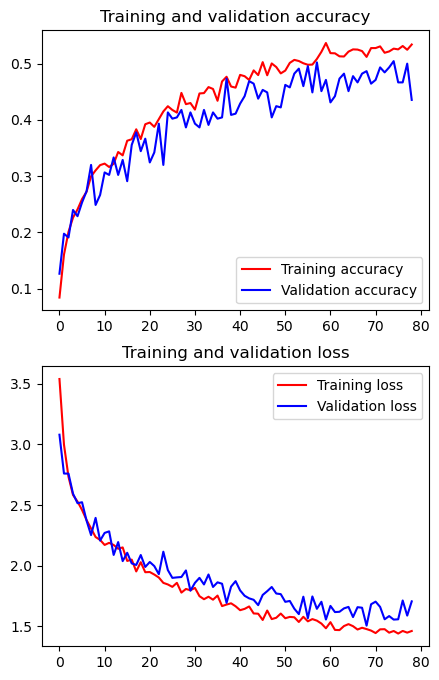

In [22]:
# Plot the results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize=(5,8))
fig.add_subplot(211)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

fig.add_subplot(212)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.savefig('/home/trahm/Desktop/ML_Degree/ML_Tensorflow/Accuracy_Loss_DNN_Baseline.png', dpi=200, bbox_inches='tight')
plt.show()

In [157]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize=(5,8))
fig.add_subplot(211)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
#plt.xlim(0,18)

fig.add_subplot(212)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
#plt.xlim(0,18)

plt.show()

NameError: name 'history' is not defined